In [63]:
import pandas as pd
import numpy as np
from model import HpaModel
import torch
import torch.utils.data as data
import h5py
from tqdm import tqdm
import os
import albumentations as albu
import matplotlib.pyplot as plt

In [6]:
main_df = pd.read_csv('../data/cell_mask_study_30000.csv')
main_df['is_single'] = main_df[[str(i) for i in range(0,19)]].apply(np.sum, axis=1)

In [7]:
main_df.head()

,Unnamed: 0,ID,Label,0,1,2,3,4,5,6,...,13,14,15,16,17,18,fold,total_cell_mask,selected_cells,is_single
0,0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8|5|0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,8,7,3
1,1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14|0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,15,15,2
2,2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6|1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,2,17,16,2
3,3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,16|10,0,0,0,0,0,0,0,...,0,0,0,1,0,0,2,17,17,2
4,4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,14|0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,45,43,2


In [4]:
#FOLD = 0
#train_df = main_df[main_df['fold']!=FOLD]
#train_df.head()

In [8]:
#lets take images with more than 10 cells and have classes greater than 2
feature_extractor_interest = main_df[(main_df['selected_cells'] >10) & (main_df['is_single'] > 1)] 

print('this is main ',main_df.shape)
print('this is FE ',feature_extractor_interest.shape)
feature_extractor_interest.head()

this is main  (21806, 26)
this is FE  (9855, 26)


,Unnamed: 0,ID,Label,0,1,2,3,4,5,6,...,13,14,15,16,17,18,fold,total_cell_mask,selected_cells,is_single
1,1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14|0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,15,15,2
2,2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6|1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,2,17,16,2
3,3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,16|10,0,0,0,0,0,0,0,...,0,0,0,1,0,0,2,17,17,2
4,4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,14|0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,45,43,2
8,8,5dd74816-bb99-11e8-b2b9-ac1f6b6435d0,12|0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,3,23,22,2


In [30]:
class hpa_dataset(data.Dataset):
    def __init__(self, ids, selected_cells, path):
        self.ids = ids
        self.selected_cells = selected_cells
        self.path = path
        self.float_conv = albu.Compose([albu.ToFloat(max_value=255.,always_apply=True)])
    def __len__(self):
        return len(self.selected_cells)
    
    def __getitem__(self, idx):
        i = selected_cells[idx]
        hdf5_path = os.path.join(self.path,self.ids,f'{self.ids}_{i}.hdf5')
        with h5py.File(hdf5_path,"r") as h:
            vv = h['train_img'][...]
            vv = self.float_conv(image= vv)["image"]
            rf = h['protein_rf'][...] - 0.5 ##this 0.5 is to zero center the values
        #print('this is rf ', rf)
        rf_np = np.full(shape = (224,224), fill_value = rf)
        vv = np.dstack([vv,rf_np])
                    
        return { 'image':vv}

In [15]:
vees = 'v6_2_1'
n_classes = 19
device = torch.device("cuda:0")
MODEL_PATH = f'../weights/version_{vees}'
metric_use = 'loss'
model_fold_0 = HpaModel(classes = n_classes, device = device, 
                        base_model_name = 'resnest50', features = 2048, pretrained = False)

model_fold_0.load_state_dict(torch.load(f"{MODEL_PATH}/st_fold_{0}_seed_1/model_st_{metric_use}_{0}.pth",map_location = device))
model_fold_0.to(device)
model_fold_0.eval()

Using cache found in /root/.cache/torch/hub/zhanghang1989_ResNeSt_master


the list  [Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): SplAtConv2d(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2, bia

HpaModel(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv

In [ ]:

### lets try with our  resnet50 v6_2_1 model for now. lets see what it can do for us

total_sample = len(feature_extractor_interest)
path = '../data/train_h5_224_30000_v4'
BATCH_SIZE = 64
WORKERS = 10

ids_list = []
count_list = []
feature_vec = []
label_list = []

for idx in range(total_sample):
    info = feature_extractor_interest.iloc[idx]
    ids = info["ID"]
    is_single = info["is_single"]
    label = info["Label"]
    selected_cells = [i for i in range(1,info["selected_cells"]+1)]
    
    test_dataset = hpa_dataset(ids, selected_cells, path)
    test_dataloader = data.DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=WORKERS,
        drop_last=False,
        pin_memory=True,
        
    )
    with torch.no_grad():
        for data_t in tqdm(test_dataloader):
            X = data_t['image'].to(device, dtype=torch.float)
            X = X.unsqueeze(0).permute(0,1,4,2,3)
            spe = model_fold_0.extract_features(X)
            #print('X ',X.min(),X.max())
            #print('this is spe ',spe.shape)
            feature_vec.extend(spe.squeeze(0).detach().cpu().numpy())
            
    ids_list.extend([ids]*len(selected_cells))
    count_list.extend(selected_cells)
    label_list.extend([label]*len(selected_cells))
    
    
    
    

100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

In [36]:
feature_vec

[array([0.06196894, 0.        , 0.90007067, ..., 0.        , 0.        ,
        0.        ], dtype=float32),
 array([0.        , 0.        , 0.06093913, ..., 0.        , 0.        ,
        0.        ], dtype=float32),
 array([0.20830913, 0.        , 0.90941715, ..., 0.        , 0.        ,
        0.        ], dtype=float32),
 array([0.03964429, 0.        , 0.53095627, ..., 0.        , 0.        ,
        0.        ], dtype=float32),
 array([0.        , 0.        , 0.36466232, ..., 0.        , 0.        ,
        0.        ], dtype=float32),
 array([0.11372322, 0.        , 0.2945654 , ..., 0.        , 0.        ,
        0.        ], dtype=float32),
 array([0.21549992, 0.        , 1.0673541 , ..., 0.        , 0.        ,
        0.        ], dtype=float32),
 array([0.        , 0.        , 0.24009557, ..., 0.        , 0.        ,
        0.        ], dtype=float32),
 array([0.04598895, 0.        , 0.26542598, ..., 0.        , 0.        ,
        0.        ], dtype=float32),
 array([0.

In [69]:
cell_feature_extract = pd.DataFrame.from_dict({'ID':ids_list, 'count':count_list, 'Label':label_list})
cell_feature_extract[[str(i) for i in range(1,2048+1)]] = np.array(feature_vec)

In [70]:
cell_feature_extract.head()

,ID,count,Label,1,2,3,4,5,6,7,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048
0,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,1,14|0,0.061969,0.0,0.900071,0.0223,0.0,0.053071,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,2,14|0,0.000000,0.0,0.060939,0.0000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,3,14|0,0.208309,0.0,0.909417,0.0000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,4,14|0,0.039644,0.0,0.530956,0.0000,0.0,0.031274,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,5,14|0,0.000000,0.0,0.364662,0.0000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
cell_feature_extract['Label'].unique()

array(['14|0', '6|1', '16|10'], dtype=object)

In [72]:
import sklearn#.cluster import DBSCAN
from sklearn.cluster import DBSCAN, KMeans

In [52]:
clustering = DBSCAN(eps=2, min_samples=3).fit_predict(cell_feature_extract[[str(i) for i in range(1,2048+1)]].values)

In [53]:
clustering

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1,
        0, -1,  0, -1,  0,  0,  0,  0,  0, -1, -1,  0, -1,  0,  0, -1,  0,
        0,  0,  0, -1, -1,  0, -1, -1, -1,  0,  0, -1, -1,  0,  0,  0,  0,
        0, -1,  0,  0,  0, -1])

In [79]:
cell_feature_extract['count'].values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43])

In [80]:
km_cluster = KMeans(n_clusters=19).fit_predict(cell_feature_extract[[str(i) for i in range(1,2048+1)]].values)

In [81]:
km_cluster

array([2, 3, 2, 2, 3, 2, 2, 2, 2, 0, 3, 2, 2, 2, 2, 4, 5, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 5, 4, 4, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 3, 0, 3, 3, 3, 0, 0, 3, 3, 0, 3, 3, 0, 0, 0, 0,
       0, 3, 0, 0, 0, 3, 3, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0,
       0, 0, 3], dtype=int32)

In [56]:
from sklearn.decomposition import PCA #Principal Component Analysis

In [57]:

pca_2d = PCA(n_components=2)
pca_2d_viz = pca_2d.fit_transform(cell_feature_extract[[str(i) for i in range(1,2048+1)]].values)

In [65]:
pca_2d_viz.shape

(91, 2)

In [60]:
import plotly as py
import plotly.graph_objs as go

In [61]:
'''trace2 = go.Scatter(
                    x = pca_2d_viz,
                    y = clustering,
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)'''

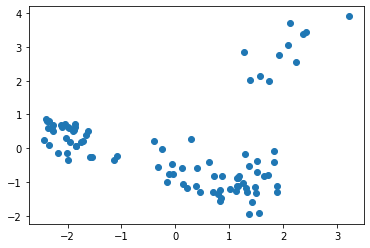

In [66]:
plt.scatter(pca_2d_viz[:,0],pca_2d_viz[:,1])

## lets try the 16bit dataset

In [6]:
import os
import cv2
import matplotlib.pyplot as plt
import imageio

In [2]:
os.listdir('../data/train_ext/HPA-Challenge-2021-trainset-extra')

['154_C1_2_yellow.png',
 '1216_E4_2_blue.png',
 '727_F8_1_yellow.png',
 '113_C8_2_green.png',
 '154_D10_1_red.png',
 '434_C7_2_red.png',
 '409_E1_1_blue.png',
 '1118_G2_2_blue.png',
 '91_E10_1_blue.png',
 '467_G4_1_red.png',
 '1141_E7_1_red.png',
 '1286_B6_3_green.png',
 '89_B4_1_green.png',
 '1669_F11_1_yellow.png',
 '492_B4_3_blue.png',
 '1893_H21_27_green.png',
 '1886_G11_5_green.png',
 '1466_A2_2_yellow.png',
 '943_D3_2_blue.png',
 '1543_G7_2_red.png',
 '23_C4_1_blue.png',
 '1616_G5_2_yellow.png',
 '480_E5_2_green.png',
 '492_F1_1_green.png',
 '423_G9_1_green.png',
 '63_B9_3_green.png',
 '1376_H2_2_green.png',
 '1595_E3_3_yellow.png',
 '618_G4_4_red.png',
 '481_F1_1_red.png',
 '914_F7_4_blue.png',
 '159_H6_1_blue.png',
 '423_E11_2_red.png',
 '1_C2_1_red.png',
 '204_F1_1_yellow.png',
 '798_H1_3_yellow.png',
 '1887_F3_5_green.png',
 '342_H2_2_blue.png',
 '131_A9_1_blue.png',
 '1743_G1_28_yellow.png',
 '1398_C2_1_blue.png',
 '50_E5_2_green.png',
 '1183_F5_1_yellow.png',
 '1958_A3_2_ye

In [8]:
img_16 = cv2.imread('../data/train_ext/HPA-Challenge-2021-trainset-extra/91_E10_1_blue.png', cv2.IMREAD_UNCHANGED)
print(img_16.shape,img_16.min(),img_16.max())

(1728, 1728) 0 255


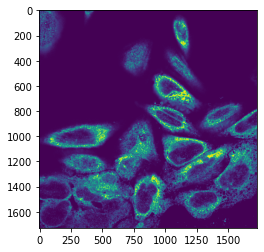

In [4]:
plt.imshow(img_16)

In [7]:
img_16  = imageio.imread('../data/train_ext/HPA-Challenge-2021-trainset-extra/154_C1_2_yellow.png')
print(img_16.shape,img_16.min(),img_16.max())

(1728, 1728) 0 255
